In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from matplotlib.patches import Circle
%matplotlib inline
import numpy as np
from math import atan2
import matplotlib.pyplot as plt
import importlib

import spline
importlib.reload(spline)
from spline import minsnap

import sense
importlib.reload(sense)
from sense import Sense

import robot
importlib.reload(robot)
from robot import Robot

import target
importlib.reload(target)
from target import Target
'''
#######################################
# ZMB Goals

- Get the ellipse working
- Ensure motion is working properly
- Ensure trajectory for robot is following target
- Make sure robot continues to follow target as long as it is moving


'''

/shared-libs/python3.8/py/lib/python3.8/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.17.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'\n#######################################\n# ZMB Goals\n\n- Get the ellipse working\n- Ensure motion is working properly\n- Ensure trajectory for robot is following target\n- Make sure robot continues to follow target as long as it is moving\n\n\n'

In [2]:
class Target(object):
    def __init__(self,arenaSize,targetMotConstraints):
        self.setMachineParameters(targetMotConstraints)
        self.point2CV_MotionTable = []
        self.CV2CV_MotionTable = []


    def setMachineParameters(self, machineParams):
        # Use this function to set the machine parameters, will raise an error if list length is 1 or 2
        if len(machineParams)<6 and len(machineParams)>0:
            raise Exception('Not enough arguments in list. Must pass a list with Vmax, Amax, Jmax, and Sampling Frequency')
        if len(machineParams)==6:
            self.Vmax = float(machineParams[0])
            self.Amax = float(machineParams[1])
            self.Jmax = float(machineParams[2])
            self.bearingRange = float(machineParams[3])
            self.bearingRate = float(machineParams[4])
            self.sampFreq = float(machineParams[5])
            self.settlingTime = 0
    
    def p2pMotionFinalTime(self,xStart, xStop, cycleTime = 0, delayTime = 0):
		# This function will generate trajectories for a point to point motion
		## fs			= Sampling frequency, will effect final time
		## xStart 		= Start position
		## xStop 		= End position
		## cycleTime	= If provided, will give the time at which the move should end
		## delayTime 	= If provided, will add a delay to the calculated time

		# This function will return the motion time

        V = self.Vmax
        A = self.Amax
        J = self.Jmax
        fs = self.sampFreq

        # First, lets determine if the Amax value needs to be adjusted based on the values of Vmax and Jmax
        if V * J < A ** 2:
            A = np.sqrt(V * J)

        # Lets determine the direction and distance of the move
        direction = np.sign(xStop - xStart)
        pT = np.abs(xStop - xStart)

        # Now lets calculate the shortest distance required for Amax to be reached, as well as the time
        pAJ = (2 * A ** 3) / (J ** 2)
        TAJ = (4 * A) / J

        # Now lets calculate the shortest distance required for Vmax to be reached, as well as the time
        pVAJ = V ** 2 / A + (A * V) / J
        TVAJ = (2 * A) / J + (2 * V) / A

        # Depending on the total distance of the move, Amax or Vmax may not be reached, which effects the number of
        # motion segments there are. Below we determine the time at which each motion segment begins

        if pT >= pVAJ:  # Seven Segments
            # t1 = A / J
            # t2 = V / A
            # t3 = A / J + V / A
            # t4 = pT / V
            # t5 = A / J + pT / V
            # t6 = V / A + pT / V
            T = A / J + V / A + pT / V

        elif pT > pAJ:  # Five Segments
            # t1 = A / J
            # t2 = (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / (2 * A) - A / (2 * J)
            # t3 = (3 * A) / (2 * J) + (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / (2 * A)
            # t4 = (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / A
            T = A / J + (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / A

        else:
            T = ((32 * pT) / J) ** (1 / 3)
            # t1 = T / 4
            # t2 = (3 * T) / 4

        # dt = 1 / fs  # Sampling interval

        # Now lets determine the final time
        if cycleTime - self.settlingTime > T:
            # The motion should be scaled to finish in the requested cycle time
            # Will need to recalculate the times with the new scaled V, A, and J

            # First, lets scale V, A, and J
            scaleFactor = T / (cycleTime - self.settlingTime)
            V = V * scaleFactor
            A = A * scaleFactor ** 2
            J = J * scaleFactor ** 3

            # Now lets calculate the shortest distance required for Amax to be reached, as well as the time
            pAJ = (2 * A ** 3) / (J ** 2)
            TAJ = (4 * A) / J

            # Now lets calculate the shortest distance required for Vmax to be reached, as well as the time
            pVAJ = V ** 2 / A + (A * V) / J
            TVAJ = (2 * A) / J + (2 * V) / A

            # Depending on the total distance of the move, Amax or Vmax may not be reached, which effects the number of
            # motion segments there are. Below we determine the time at which each motion segment begins

            if pT >= pVAJ:  # Seven Segments
                t1 = A / J
                t2 = V / A
                t3 = A / J + V / A
                t4 = pT / V
                t5 = A / J + pT / V
                t6 = V / A + pT / V
                T = A / J + V / A + pT / V

            elif pT > pAJ:  # Five Segments
                t1 = A / J
                t2 = (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / (2 * A) - A / (2 * J)
                t3 = (3 * A) / (2 * J) + (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / (2 * A)
                t4 = (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / A
                T = A / J + (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / A

            else:
                T = ((32 * pT) / J) ** (1 / 3)
                t1 = T / 4
                t2 = (3 * T) / 4
            Tf = T + self.settlingTime
        # If there is a delay, add that to the final time

        else:
            Tf = T + self.settlingTime


        return Tf

    def p2pMotionTrajectoryGenerator(self, xStart, xStop, cycleTime = 0, delayTime = 0):
		# This function will generate trajectories for a point to point motion
		## fs			= Sampling frequency, will effect final time
		## xStart 		= Start position
		## xStop 		= End position
		## cycleTime	= If provided, will give the time at which the move should end
		## delayTime 	= If provided, will add a delay to the calculated time

		# This function will return the motion time, as well as the trajectory of pos, vel, acc, and jerk

        V = self.Vmax
        A = self.Amax
        J = self.Jmax
        fs = self.sampFreq

        # First, lets make sure the start and stop positions are different
        if xStart == xStop:
            # If they are the same, the axis doesn't move, so for the cycleTime duration, the axis stays at xStart
            if cycleTime==0:
                return 0, [np.array([]), np.array([]), np.array([]), np.array([]), np.array([])]
            else:
                return 0, [np.array([[0,fs*np.floor(cycleTime/fs)]]), np.array([[xStart,xStart]]), np.array([[0,0]]), np.array([[0,0]]), np.array([[0,0]])]


        # First, lets determine if the Amax value needs to be adjusted based on the values of Vmax and Jmax
        if V*J < A**2:
            A = np.sqrt(V*J)

        # Lets determine the direction and distance of the move
        direction = np.sign(xStop - xStart)
        pT = np.abs(xStop - xStart)

        # Now lets calculate the shortest distance required for Amax to be reached, as well as the time
        pAJ = (2*A**3)/(J**2)
        TAJ = (4*A)/J

        # Now lets calculate the shortest distance required for Vmax to be reached, as well as the time
        pVAJ = V**2/A + (A*V)/J
        TVAJ = (2*A)/J + (2*V)/A

        # Depending on the total distance of the move, Amax or Vmax may not be reached, which effects the number of
        # motion segments there are. Below we determine the time at which each motion segment begins

        if pT >= pVAJ:	# Seven Segments
            t1 = A/J
            t2 = V/A
            t3 = A/J + V/A
            t4 = pT/V
            t5 = A/J + pT/V
            t6 = V/A + pT/V
            T = A/J + V/A + pT/V

        elif pT>pAJ:	# Five Segments
            t1 = A/J
            t2 = (4*A*pT + A**4/J**2)**(1/2)/(2*A) - A/(2*J)
            t3 = (3 * A) / (2 * J) + (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / (2 * A)
            t4 = (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / A
            T = A / J + (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / A

        else:
            T = ((32*pT)/J)**(1/3)
            t1 = T/4
            t2 = (3*T)/4

        dt = 1/fs	# Sampling interval


        # Now lets determine the final time

        if cycleTime-self.settlingTime>T:
            # The motion should be scaled to finish in the requested cycle time
            # Will need to recalculate the times with the new scaled V, A, and J

            # First, lets scale V, A, and J
            scaleFactor = T/(cycleTime-self.settlingTime)
            V = V*scaleFactor
            A = A*scaleFactor**2
            J = J*scaleFactor**3

            # Now lets calculate the shortest distance required for Amax to be reached, as well as the time
            pAJ = (2 * A ** 3) / (J ** 2)
            TAJ = (4 * A) / J

            # Now lets calculate the shortest distance required for Vmax to be reached, as well as the time
            pVAJ = V ** 2 / A + (A * V) / J
            TVAJ = (2 * A) / J + (2 * V) / A

            # Depending on the total distance of the move, Amax or Vmax may not be reached, which effects the number of
            # motion segments there are. Below we determine the time at which each motion segment begins

            if pT >= pVAJ:  # Seven Segments
                t1 = A / J
                t2 = V / A
                t3 = A / J + V / A
                t4 = pT / V
                t5 = A / J + pT / V
                t6 = V / A + pT / V
                T = A / J + V / A + pT / V

            elif pT > pAJ:  # Five Segments
                t1 = A / J
                t2 = (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / (2 * A) - A / (2 * J)
                t3 = (3 * A) / (2 * J) + (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / (2 * A)
                t4 = (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / A
                T = A / J + (4 * A * pT + A ** 4 / J ** 2) ** (1 / 2) / A

            else:
                T = ((32 * pT) / J) ** (1 / 3)
                t1 = T / 4
                t2 = (3 * T) / 4
            Tf = T+self.settlingTime
            # If there is a delay, add that to the final time


        else:
            Tf = T+self.settlingTime

        if delayTime > 0:
            Tf = delayTime + Tf

        steps = np.arange(0,T,dt).reshape(-1,1)
        pos = np.zeros((steps.shape[0],1))
        vel = np.zeros((steps.shape[0],1))
        acc = np.zeros((steps.shape[0],1))
        jerk = np.zeros((steps.shape[0],1))

        # Lets fill out the trajectory arrays created above
        if pT>=pVAJ:		# 7 Segments
            # Positions
            pos[np.logical_and(steps<t1,steps>=0)] = (J*steps[np.logical_and(steps<t1,steps>=0)]**3)/6
            pos[np.logical_and(steps<t2,steps>=t1)] = (A*steps[np.logical_and(steps<t2,steps>=t1)]**2)/2 + A**3/(6*J**2) - (A**2*steps[np.logical_and(steps<t2,steps>=t1)])/(2*J)
            pos[np.logical_and(steps < t3, steps >= t2)] = (A*steps[np.logical_and(steps<t3,steps>=t2)]**2)/2 - (J*steps[np.logical_and(steps<t3,steps>=t2)]**3)/6 + (J*t2**3)/6 + A**3/(6*J**2) - (A**2*steps[np.logical_and(steps<t3,steps>=t2)])/(2*J) - (J*steps[np.logical_and(steps<t3,steps>=t2)]*t2**2)/2 + (J*steps[np.logical_and(steps<t3,steps>=t2)]**2*t2)/2
            pos[np.logical_and(steps < t4, steps >= t3)] = (J*t2**3)/6 - (A*t3**2)/2 + (J*t3**3)/3 + A**3/(6*J**2) - (A**2*steps[np.logical_and(steps<t4,steps>=t3)])/(2*J) + A*steps[np.logical_and(steps<t4,steps>=t3)]*t3 - (J*steps[np.logical_and(steps<t4,steps>=t3)]*t2**2)/2 - (J*steps[np.logical_and(steps<t4,steps>=t3)]*t3**2)/2 - (J*t2*t3**2)/2 + J*steps[np.logical_and(steps<t4,steps>=t3)]*t2*t3
            pos[np.logical_and(steps < t5, steps >= t4)] = (J*t2**3)/6 - (J*steps[np.logical_and(steps<t5,steps>=t4)]**3)/6 - (A*t3**2)/2 + (J*t3**3)/3 + (J*t4**3)/6 + A**3/(6*J**2) - (A**2*steps[np.logical_and(steps<t5,steps>=t4)])/(2*J) + A*steps[np.logical_and(steps<t5,steps>=t4)]*t3 - (J*steps[np.logical_and(steps<t5,steps>=t4)]*t2**2)/2 - (J*steps[np.logical_and(steps<t5,steps>=t4)]*t3**2)/2 - (J*steps[np.logical_and(steps<t5,steps>=t4)]*t4**2)/2 + (J*steps[np.logical_and(steps<t5,steps>=t4)]**2*t4)/2 - (J*t2*t3**2)/2 + J*steps[np.logical_and(steps<t5,steps>=t4)]*t2*t3
            pos[np.logical_and(steps < t6, steps >= t5)] = (J*t2**3)/6 - (A*t3**2)/2 - (A*t5**2)/2 - (A*steps[np.logical_and(steps<t6,steps>=t5)]**2)/2 + (J*t3**3)/3 + (J*t4**3)/6 + (J*t5**3)/3 + A**3/(6*J**2) - (A**2*steps[np.logical_and(steps<t6,steps>=t5)])/(2*J) + A*steps[np.logical_and(steps<t6,steps>=t5)]*t3 + A*steps[np.logical_and(steps<t6,steps>=t5)]*t5 - (J*steps[np.logical_and(steps<t6,steps>=t5)]*t2**2)/2 - (J*steps[np.logical_and(steps<t6,steps>=t5)]*t3**2)/2 - (J*steps[np.logical_and(steps<t6,steps>=t5)]*t4**2)/2 - (J*steps[np.logical_and(steps<t6,steps>=t5)]*t5**2)/2 - (J*t2*t3**2)/2 - (J*t4*t5**2)/2 + J*steps[np.logical_and(steps<t6,steps>=t5)]*t2*t3 + J*steps[np.logical_and(steps<t6,steps>=t5)]*t4*t5
            pos[np.logical_and(steps < T, steps >= t6)] = (J*steps[np.logical_and(steps<T,steps>=t6)]**3)/6 - (A*t3**2)/2 - (A*t5**2)/2 - (A*steps[np.logical_and(steps<T,steps>=t6)]**2)/2 + (J*t2**3)/6 + (J*t3**3)/3 + (J*t4**3)/6 + (J*t5**3)/3 - (J*t6**3)/6 + A**3/(6*J**2) - (A**2*steps[np.logical_and(steps<T,steps>=t6)])/(2*J) + A*steps[np.logical_and(steps<T,steps>=t6)]*t3 + A*steps[np.logical_and(steps<T,steps>=t6)]*t5 - (J*steps[np.logical_and(steps<T,steps>=t6)]*t2**2)/2 - (J*steps[np.logical_and(steps<T,steps>=t6)]*t3**2)/2 - (J*steps[np.logical_and(steps<T,steps>=t6)]*t4**2)/2 - (J*steps[np.logical_and(steps<T,steps>=t6)]*t5**2)/2 - (J*t2*t3**2)/2 + (J*steps[np.logical_and(steps<T,steps>=t6)]*t6**2)/2 - (J*steps[np.logical_and(steps<T,steps>=t6)]**2*t6)/2 - (J*t4*t5**2)/2 + J*steps[np.logical_and(steps<T,steps>=t6)]*t2*t3 + J*steps[np.logical_and(steps<T,steps>=t6)]*t4*t5
            pos[steps >= T] =(J*T**3)/6 - (A*t3**2)/2 - (A*t5**2)/2 - (A*T**2)/2 + (J*t2**3)/6 + (J*t3**3)/3 + (J*t4**3)/6 + (J*t5**3)/3 - (J*t6**3)/6 + A**3/(6*J**2) - (A**2*T)/(2*J) + A*T*t3 + A*T*t5 - (J*T*t2**2)/2 - (J*T*t3**2)/2 - (J*T*t4**2)/2 - (J*T*t5**2)/2 - (J*t2*t3**2)/2 + (J*T*t6**2)/2 - (J*T**2*t6)/2 - (J*t4*t5**2)/2 + J*T*t2*t3 + J*T*t4*t5

            # Velocities
            vel[np.logical_and(steps<t1,steps>=0)] = (J*steps[np.logical_and(steps<t1,steps>=0)]**2)/2
            vel[np.logical_and(steps<t2,steps>=t1)] = -A**2/(2*J) + steps[np.logical_and(steps<t2,steps>=t1)]*A
            vel[np.logical_and(steps < t3, steps >= t2)] = - A**2/(2*J) + steps[np.logical_and(steps<t3,steps>=t2)]*A - (J*steps[np.logical_and(steps<t3,steps>=t2)]**2)/2 - (J*t2**2)/2 + J*steps[np.logical_and(steps<t3,steps>=t2)]*t2
            vel[np.logical_and(steps < t4, steps >= t3)] =- A**2/(2*J) + t3*A - (J*t2**2)/2 - (J*t3**2)/2 + J*t2*t3
            vel[np.logical_and(steps < t5, steps >= t4)] =- A**2/(2*J) + t3*A - (J*steps[np.logical_and(steps<t5,steps>=t4)]**2)/2 - (J*t2**2)/2 - (J*t3**2)/2 - (J*t4**2)/2 + J*steps[np.logical_and(steps<t5,steps>=t4)]*t4 + J*t2*t3;
            vel[np.logical_and(steps < t6, steps >= t5)] =A*t3 - A*steps[np.logical_and(steps<t6,steps>=t5)] + A*t5 - (J*t2**2)/2 - (J*t3**2)/2 - (J*t4**2)/2 - (J*t5**2)/2 - A**2/(2*J) + J*t2*t3 + J*t4*t5
            vel[np.logical_and(steps < T, steps >= t6)] =A*t3 - A*steps[np.logical_and(steps<T,steps>=t6)] + A*t5 + (J*steps[np.logical_and(steps<T,steps>=t6)]**2)/2 - (J*t2**2)/2 - (J*t3**2)/2 - (J*t4**2)/2 - (J*t5**2)/2 + (J*t6**2)/2 - A**2/(2*J) + J*t2*t3 - J*steps[np.logical_and(steps<T,steps>=t6)]*t6 + J*t4*t5
            vel[steps >= T] = 0

            # Accelerations
            acc[np.logical_and(steps<t1,steps>=0)] = J*steps[np.logical_and(steps<t1,steps>=0)]
            acc[np.logical_and(steps<t2,steps>=t1)] = A
            acc[np.logical_and(steps < t3, steps >= t2)] =A - J*steps[np.logical_and(steps<t3,steps>=t2)] + J*t2
            acc[np.logical_and(steps < t4, steps >= t3)] =0
            acc[np.logical_and(steps < t5, steps >= t4)] =J*t4 - J*steps[np.logical_and(steps<t5,steps>=t4)]
            acc[np.logical_and(steps < t6, steps >= t5)] = -A
            acc[np.logical_and(steps < T, steps >= t6)] = J*steps[np.logical_and(steps<T,steps>=t6)] - A - J*t6
            acc[steps >= T] = 0

            # Jerks
            jerk[np.logical_and(steps < t1, steps >= 0)] = J
            jerk[np.logical_and(steps < t2, steps >= t1)] = 0
            jerk[np.logical_and(steps < t3, steps >= t2)] = -J
            jerk[np.logical_and(steps < t4, steps >= t3)] = 0
            jerk[np.logical_and(steps < t5, steps >= t4)] = -J
            jerk[np.logical_and(steps < t6, steps >= t5)] = 0
            jerk[np.logical_and(steps < T, steps >= t6)] = J
            jerk[steps >= T] = 0
        elif pT>pAJ:		# 5 Segments
            # Positions
            pos[np.logical_and(steps<t1,steps>=0)] =(J*steps[np.logical_and(steps<t1,steps>=0)]**3)/6
            pos[np.logical_and(steps<t2,steps>=t1)] =(A*steps[np.logical_and(steps<t2,steps>=t1)]**2)/2 + (J*steps[np.logical_and(steps<t2,steps>=t1)]*t1**2)/2 - A*steps[np.logical_and(steps<t2,steps>=t1)]*t1 - (J*t1**3)/3 + (A*t1**2)/2
            pos[np.logical_and(steps < t3, steps >= t2)] =- (J*steps[np.logical_and(steps<t3,steps>=t2)]**3)/6 + (J*steps[np.logical_and(steps<t3,steps>=t2)]**2*t2)/2 + (A*steps[np.logical_and(steps<t3,steps>=t2)]**2)/2 + (J*steps[np.logical_and(steps<t3,steps>=t2)]*t1**2)/2 - A*steps[np.logical_and(steps<t3,steps>=t2)]*t1 - (J*steps[np.logical_and(steps<t3,steps>=t2)]*t2**2)/2 - (J*t1**3)/3 + (A*t1**2)/2 + (J*t2**3)/6
            pos[np.logical_and(steps < t4, steps >= t3)] =(A*t1**2)/2 - (A*steps[np.logical_and(steps<t4,steps>=t3)]**2)/2 - A*t3**2 - (J*t1**3)/3 + (J*t2**3)/6 + (J*t3**3)/3 - A*steps[np.logical_and(steps<t4,steps>=t3)]*t1 + 2*A*steps[np.logical_and(steps<t4,steps>=t3)]*t3 + (J*steps[np.logical_and(steps<t4,steps>=t3)]*t1**2)/2 - (J*steps[np.logical_and(steps<t4,steps>=t3)]*t2**2)/2 - (J*steps[np.logical_and(steps<t4,steps>=t3)]*t3**2)/2 - (J*t2*t3**2)/2 + J*steps[np.logical_and(steps<t4,steps>=t3)]*t2*t3
            pos[np.logical_and(steps < T, steps >= t4)] =(J*steps[np.logical_and(steps<T,steps>=t4)]**3)/6 - (J*steps[np.logical_and(steps<T,steps>=t4)]**2*t4)/2 - (A*steps[np.logical_and(steps<T,steps>=t4)]**2)/2 + (J*steps[np.logical_and(steps<T,steps>=t4)]*t1**2)/2 - A*steps[np.logical_and(steps<T,steps>=t4)]*t1 - (J*steps[np.logical_and(steps<T,steps>=t4)]*t2**2)/2 + J*steps[np.logical_and(steps<T,steps>=t4)]*t2*t3 - (J*steps[np.logical_and(steps<T,steps>=t4)]*t3**2)/2 + 2*A*steps[np.logical_and(steps<T,steps>=t4)]*t3 + (J*steps[np.logical_and(steps<T,steps>=t4)]*t4**2)/2 - (J*t1**3)/3 + (A*t1**2)/2 + (J*t2**3)/6 - (J*t2*t3**2)/2 + (J*t3**3)/3 - A*t3**2 - (J*t4**3)/6
            pos[steps >= T] =(J*T**3)/6 - (J*T**2*t4)/2 - (A*T**2)/2 + (J*T*t1**2)/2 - A*T*t1 - (J*T*t2**2)/2 + J*T*t2*t3 - (J*T*t3**2)/2 + 2*A*T*t3 + (J*T*t4**2)/2 - (J*t1**3)/3 + (A*t1**2)/2 + (J*t2**3)/6 - (J*t2*t3**2)/2 + (J*t3**3)/3 - A*t3**2 - (J*t4**3)/6

            # Velocities
            vel[np.logical_and(steps < t1, steps >= 0)] =(J*steps[np.logical_and(steps<t1,steps>=0)]**2)/2
            vel[np.logical_and(steps < t2, steps >= t1)] =(J*t1**2)/2 - A*t1 + A*steps[np.logical_and(steps<t2,steps>=t1)]
            vel[np.logical_and(steps < t3, steps >= t2)] =(J*t1**2)/2 - A*t1 + A*steps[np.logical_and(steps<t3,steps>=t2)] - (J*steps[np.logical_and(steps<t3,steps>=t2)]**2)/2 - (J*t2**2)/2 + J*steps[np.logical_and(steps<t3,steps>=t2)]*t2
            vel[np.logical_and(steps < t4, steps >= t3)] =(J*t1**2)/2 - A*t1 - A*steps[np.logical_and(steps<t4,steps>=t3)] + 2*A*t3 - (J*t2**2)/2 - (J*t3**2)/2 + J*t2*t3
            vel[np.logical_and(steps < T, steps >= t4)] =(J*steps[np.logical_and(steps<T,steps>=t4)]**2)/2 - J*steps[np.logical_and(steps<T,steps>=t4)]*t4 - A*steps[np.logical_and(steps<T,steps>=t4)] + (J*t1**2)/2 - A*t1 + (J*t4**2)/2 + 2*A*t3 - (J*t2**2)/2 - (J*t3**2)/2 + J*t2*t3
            vel[steps >= T] = 0

            # Accelerations
            acc[np.logical_and(steps < t1, steps >= 0)] =J*steps[np.logical_and(steps<t1,steps>=0)]
            acc[np.logical_and(steps < t2, steps >= t1)] =A
            acc[np.logical_and(steps < t3, steps >= t2)] =A - J*steps[np.logical_and(steps<t3,steps>=t2)] + J*t2
            acc[np.logical_and(steps < t4, steps >= t3)] =-A
            acc[np.logical_and(steps < T, steps >= t4)] = J*steps[np.logical_and(steps<T,steps>=t4)] - A - J*t4
            acc[steps >= T] = 0

            # Jerks
            jerk[np.logical_and(steps < t1, steps >= 0)] = J
            jerk[np.logical_and(steps < t2, steps >= t1)] = 0
            jerk[np.logical_and(steps < t3, steps >= t2)] =-J
            jerk[np.logical_and(steps < t4, steps >= t3)] =0
            jerk[np.logical_and(steps < T, steps >= t4)] =J
            jerk[steps >= T] =0

        else:		# 3 Segments
            # Positions
            pos[np.logical_and(steps<t1,steps>=0)] =(J*steps[np.logical_and(steps<t1,steps>=0)]**3)/6
            pos[np.logical_and(steps<t2,steps>=t1)] =(J*T**3)/192 - (J*T**2*steps[np.logical_and(steps<t2,steps>=t1)])/16 + (J*T*steps[np.logical_and(steps<t2,steps>=t1)]**2)/4 - (J*steps[np.logical_and(steps<t2,steps>=t1)]**3)/6
            pos[np.logical_and(steps < T, steps >= t2)] =- (13*J*T**3)/96 + (J*T**2*steps[np.logical_and(steps<T,steps>=t2)])/2 - (J*T*steps[np.logical_and(steps<T,steps>=t2)]**2)/2 + (J*steps[np.logical_and(steps<T,steps>=t2)]**3)/6
            pos[steps >= T] =- (13*J*T**3)/96 + (J*T**2*T)/2 - (J*T*T**2)/2 + (J*T**3)/6

            # Velocities
            vel[np.logical_and(steps < t1, steps >= 0)] =(J*steps[np.logical_and(steps<t1,steps>=0)]**2)/2
            vel[np.logical_and(steps < t2, steps >= t1)] =(J*T*steps[np.logical_and(steps<t2,steps>=t1)])/2 - (J*steps[np.logical_and(steps<t2,steps>=t1)]**2)/2 - (J*T**2)/16
            vel[np.logical_and(steps < T, steps >= t2)] =(J*T**2)/2 - J*T*steps[np.logical_and(steps<T,steps>=t2)] + (J*steps[np.logical_and(steps<T,steps>=t2)]**2)/2
            vel[steps >= T] = 0

            # Accelerations
            acc[np.logical_and(steps < t1, steps >= 0)] =J*steps[np.logical_and(steps<t1,steps>=0)]
            acc[np.logical_and(steps < t2, steps >= t1)] =(J*T)/2 - J*steps[np.logical_and(steps<t2,steps>=t1)]
            acc[np.logical_and(steps < T, steps >= t2)] =J*steps[np.logical_and(steps<T,steps>=t2)] - J*T
            acc[steps >= T] = 0

            # Jerks
            jerk[np.logical_and(steps < t1, steps >= 0)] = J
            jerk[np.logical_and(steps < t2, steps >= t1)] =-J
            jerk[np.logical_and(steps < T, steps >= t2)] =J
            jerk[steps >= T] = 0

        # Finally, we need to ensure the direction of motion and start position are correct
        if direction < 0:
            pos = direction*pos+xStart
            vel = direction*vel
            acc = direction*acc
            jerk = direction*jerk
        else:
            pos = pos+xStart
        delaySteps = np.arange(0, delayTime, dt).reshape(-1, 1)
        settlingTimeSteps = np.arange(dt, self.settlingTime+dt, dt).reshape(-1, 1)+delayTime+steps[-1]
        if not np.any(delaySteps):
            delaySteps = np.vstack((delaySteps,np.array([0])))


        steps = np.vstack((delaySteps,steps+delayTime,settlingTimeSteps))
        pos = np.vstack((np.zeros((delaySteps.shape[0], 1))+xStart,pos,np.zeros((settlingTimeSteps.shape[0], 1))+xStop))
        vel = np.vstack((np.zeros((delaySteps.shape[0], 1)),vel,np.zeros((settlingTimeSteps.shape[0], 1))))
        acc = np.vstack((np.zeros((delaySteps.shape[0], 1)),acc,np.zeros((settlingTimeSteps.shape[0], 1))))
        jerk = np.vstack((np.zeros((delaySteps.shape[0], 1)),jerk,np.zeros((settlingTimeSteps.shape[0], 1))))

        return Tf, [pos, vel, acc, jerk, steps]

    def trajectorySelector(self, trajSelection,initialConditions,finalConditions,simulationTime):
        '''
        This function is used to select which trajectory will be used for the
        target.

        trajSelection == Integer
            trajSelection=0 -> Stationary
            trajSelection=1 -> Point to Point
            trajSelection=2 -> Circular
            trajSelection=3 -> Random

        initialConditions == 6x1 Numpy Array
            initialConditions[0] = X Position
            initialConditions[1] = Y Position
            initialConditions[2] = X Velocity
            initialConditions[3] = Y Velocity
            initialConditions[4] = X Acceleration
            initialConditions[5] = Y Acceleration

        finalConditions == 6x1 Numpy Array
            initialConditions[0] = X Position
            initialConditions[1] = Y Position
            initialConditions[2] = X Velocity
            initialConditions[3] = Y Velocity
            initialConditions[4] = X Acceleration
            initialConditions[5] = Y Acceleration

        simulationTime == float, total simulation time

        Function creates a self.trajectory array with shape int(simulationTime/self.sampFreq) x 5
            Column 1 = X Position
            Column 2 = Y Position
            Column 3 = X Velocity
            Column 4 = Y Velocity
            Column 5 = Step Time
        '''
        
        if trajSelection==0:    #Stationary
            self.trajectory = np.zeros((int(simulationTime*self.sampFreq),5))
            self.trajectory[:,0:2] = initialConditions[0:2]

        elif trajSelection==1:  # Point to Point
            # First, need to determine the time needed to get from initial to
            #   final position in both X and Y (p2p method is 1D). Using the
            #   largest time, I set up the trajectories
            xTF = self.p2pMotionFinalTime(initialConditions[0],finalConditions[0])
            yTF = self.p2pMotionFinalTime(initialConditions[1],finalConditions[1])

            actualTF = max(xTF,yTF)
            

            TF,xTraj = self.p2pMotionTrajectoryGenerator(initialConditions[0],finalConditions[0],actualTF)
            TF,yTraj = self.p2pMotionTrajectoryGenerator(initialConditions[1],finalConditions[1],actualTF)

            xTraj = np.array(xTraj)
            yTraj = np.array(yTraj)

            if xTraj.shape[0] > yTraj.shape[0]:
                newY = np.ones(xTraj.shape)
                newY[0:yTraj.shape[0]+1,:] = yTraj
                for ii in range(0,yTraj.shape[1]):
                    newY[yTraj.shape[0]+1:,ii]=yTraj[-1,ii]
                yTraj = newY
            else:
                newX = np.ones((yTraj.shape,len(yTraj)))
                newX[0:xTraj.shape[0]+1,:] = xTraj
                for ii in range(0,xTraj.shape[1]):
                    newX[xTraj.shape[0]+1:,ii]=xTraj[-1,ii]
                xTraj = newX


            self.trajectory = np.empty((xTraj[0].shape[0],5))
            self.trajectory[:,0] = xTraj[0].flatten()
            self.trajectory[:,1] = yTraj[0].flatten()
            self.trajectory[:,2] = xTraj[1].flatten()
            self.trajectory[:,3] = yTraj[1].flatten()
            self.trajectory[:,4] = xTraj[-1].flatten()









        # print('Hello World!')

In [3]:

######################################################################################################################################################################
#####
#####              ANIMATION
#####
######################################################################################################################################################################



# This is the animation code from HW6
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from matplotlib.patches import Circle, Ellipse, Rectangle
size = 5
def x_d(t):
  return np.zeros(size)

def create_animation(xTarget ,xRobot, tf, Arena, targetUncertainty=[], robotSize=0.1,targetSize=0.1,tailLength=10,n_frames = 60,uncertaintyFilterFlag=0):
  # Sample desired trajectory
  n_samples = 1000
  t_samples = np.linspace(0.0, tf, n_samples)
  x_des = np.zeros((n_samples, size))
  for i in range(t_samples.shape[0]):
    x_des[i] = x_d(t_samples[i])

  x_des = xTarget
  x = xRobot

  from matplotlib import rc
  rc('animation', html='jshtml')

  fig = plt.figure(figsize=(16,12))
  ax = plt.axes()

  x_max = max(np.max(x_des[:, 0]), np.max(x[:, 0]))
  x_min = min(np.min(x_des[:, 0]), np.min(x[:, 0]))
  y_max = max(np.max(x_des[:, 1]), np.max(x[:, 1]))
  y_min = min(np.min(x_des[:, 1]), np.min(x[:, 1]))
  
  frame_idx = [round(x) for x in np.linspace(0, xRobot.shape[0]-1, n_frames).tolist()]
  x_Robot = np.zeros((n_frames, size))
  x_Target = np.zeros((n_frames, size))
  for i in range(n_frames):
    x_Robot[i, :] = xRobot[frame_idx[i], :]
    x_Target[i, :] = xTarget[frame_idx[i], :]
    targetUncertainty[i, :] = targetUncertainty[frame_idx[i], :]

  a = 0.25
#   y = x_anim[:, 0]
#   z = x_anim[:, 1]
#   theta = x_anim[:, 2]

  x_padding = 0.25 * (x_max - x_min)
  y_padding = 0.25 * (y_max - y_min)

  def frame(i):
    ax.clear()

    # Need to set up the frame, which will consist of the arena, target dot, target ellipse, robot
    # Handle the arena
    # arenaPatch = Circle((0,0),radius=Arena.arenaSize,edgecolor='r',facecolor='None')
    arenaPatch = Rectangle((arena.arenaSize[0,0],arena.arenaSize[1,0]),arena.arenaSize[0,1]-arena.arenaSize[0,0],arena.arenaSize[1,1]-arena.arenaSize[1,0],edgecolor='r',facecolor='None')
    ax.add_patch(arenaPatch)

    # Handle the target
    if targetSize>0:
        targetPatch = Circle(x_Target[i,0:2],radius=targetSize,edgecolor='b',facecolor='b',label='Target')
        ax.add_patch(targetPatch)
    else:
        ax.plot(x_Target[i,0],x_Target[i,1],'b*',label='Target')

    # Create an ellipse to represent the uncertainty area

    # Uncertainty array has the following structure:
    # Index 0,1: Mean
    # Index 2,3: w1
    # Index 4,5: w2
    # Index 6,7: w3
    # Index 8,9: w4
    # Index 10: theta
    # Index 11,12: wStar

    if targetUncertainty.shape[0]>0:
        ellipseCenter = (targetUncertainty[i,0],targetUncertainty[i,1])
        # print(f'Ellipse Center: {ellipseCenter}')
        if uncertaintyFilterFlag==1:
            ellipseWidth = np.sqrt((targetUncertainty[i,2]-targetUncertainty[i,4])**2+(targetUncertainty[i,3]-targetUncertainty[i,5])**2)
            ellipseLength = np.sqrt((targetUncertainty[i,6]-targetUncertainty[i,8])**2+(targetUncertainty[i,7]-targetUncertainty[i,9])**2)
            ellipseAngle = targetUncertainty[i,10]
        else:
            ellipseWidth = np.sqrt(targetUncertainty[i,2]**2+targetUncertainty[i,3]**2)*2
            ellipseLength = np.sqrt(targetUncertainty[i,4]**2+targetUncertainty[i,5]**2)*2
            ellipseAngle = targetUncertainty[i,6]
        uncertaintyPatch = Ellipse(ellipseCenter,ellipseWidth,ellipseLength,ellipseAngle,edgecolor='b',facecolor='None',ls='--')
        ax.add_patch(uncertaintyPatch)

        # Will also add a red cross to signify the estimated position:
        ax.plot(ellipseCenter[0],ellipseCenter[1],'rx',label='Estimated Target Position')
        ax.plot(targetUncertainty[i,11],targetUncertainty[i,12],'b*',label='wStar')


    # Handle the robot
    if robotSize>0:
        robotPatch = Circle(x_Robot[i,0:2],radius=robotSize,edgecolor='g',facecolor='g',label='Robot')
        ax.add_patch(robotPatch)
    else:
        ax.plot(x_Robot[i,0],x_Robot[i,1],'go',label='Robot')



    prevPosIndex = np.clip(tailLength,0,i)
    # ax.plot(x_des[0, 0], x_des[0, 1], 'b*', label='desired position')
    ax.plot(x_Target[i-prevPosIndex:i+1, 0], x_Target[i-prevPosIndex:i+1, 1], 'b--', label='target trajectory')
    ax.plot(x_Robot[i-prevPosIndex:i+1, 0], x_Robot[i-prevPosIndex:i+1, 1], 'g--', label='robot trajectory')
    ax.text(Arena.arenaSize[0,1]-15,Arena.arenaSize[1,1]+4,'Simulation Time: '+str(x_Robot[i,-1])+' s')
    # plot=ax.scatter(x_anim[i, 0], x_anim[i, 1], c='r', label='quadrotor position')
    # plot = ax.plot([y[i] + a*cos(theta[i]), y[i] - a*cos(theta[i])],
    #                [z[i] + a*sin(theta[i]), z[i] - a*sin(theta[i])] , 'g','LineWidtheeta',3)
    
    # if(np.abs((x_max - x_min) - (y_max - y_min)) < 5):
    #   ax.set_xlim(x_min - x_padding, x_max + x_padding)
    #   ax.set_ylim(y_min - y_padding, y_max + y_padding)
    ax.set_xlim(Arena.arenaSize[0,0]*1.1,Arena.arenaSize[0,1]*1.1)
    ax.set_ylim(Arena.arenaSize[1,0]*1.1,Arena.arenaSize[1,1]*1.1)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_aspect('equal')
    ax.legend(loc='upper left')

    return ax

  return animation.FuncAnimation(fig, frame, frames=n_frames, blit=False, repeat=False), fig
  


In [4]:



class Robot(object):
    def __init__(self,arenaSize,targetMotConstraints,initialConditions,finalConditions,intermediatePoints=[],order=4,tolerance=0.5):
        self.setMachineParameters(targetMotConstraints)
        self.n = 1+len(intermediatePoints)
        self.d = order
        self.currentState = np.hstack((initialConditions,[0,0]))
        self.targetPos = finalConditions[0:2]#finalConditions[0:2]
        self.wStar = initialConditions[0:2]
        self.prev_wStar = self.wStar
        # Need to initialize the trajectory array
        self.trajectory = np.zeros((2,8))
        self.trajectory[0,0:6] = initialConditions
        self.trajectory[1,0:6] = initialConditions
        self.finalTrajectory = np.empty((0,8))#initialConditions[0:4]
        self.prevTraj = np.array([initialConditions,initialConditions])
        self.tolerance = tolerance
        self.trajCounter = 1
        self.trajectoryGeneratedFlag = 0
        # For now, only using two waypoints, so a single segment
        if intermediatePoints==[]:
            self.w = np.array([initialConditions,finalConditions])
        else:
            self.w = np.array([initialConditions,intermediatePoints,finalConditions])
        
        print(f'Starting waypoint size: {self.w.shape}')
        


    def setMachineParameters(self, machineParams):
        # Use this function to set the machine parameters, will raise an error if list length is 1 or 2
        if len(machineParams)<6 and len(machineParams)>0:
            raise Exception('Not enough arguments in list. Must pass a list with Vmax, Amax, Jmax, and Sampling Frequency')
        if len(machineParams)==6:
            self.Vmax = float(machineParams[0])
            self.Amax = float(machineParams[1])
            self.Jmax = float(machineParams[2])
            self.bearingRange = float(machineParams[3])
            self.bearingRate = float(machineParams[4])
            self.sampFreq = float(machineParams[5])
            self.settlingTime = 0

    def addWaypoint(self,waypoint,position):
        if position==0:
            self.w = np.vstack((waypoint,self.w))
        else:
            self.w = np.vstack((self.w[0:position,:],waypoint,self.w[position:,:]))

        # Also need to update n
        self.n = self.w.shape[0]-1

        return 0

    def addProtrusionPoint(self):
        '''
        This function will add a waypoint to shift the trajectory so that we do not enter the uncertainty zone
        '''

        midpoint = [(self.currentState[0]+self.targetPos[0])/2,(self.currentState[1]+self.targetPos[1])/2]
        
        wStarDist = np.sqrt((self.wStar[0]-self.targetPos[0])**2 + (self.wStar[1]-self.targetPos[1])**2)
        print(wStarDist)

        # Need to find where wStar is relative to current position
        targetAngle = np.arctan2((self.targetPos[1]-self.currentState[1]),(self.targetPos[0]-self.currentState[0]))
        wStarAngle = np.arctan2((self.wStar[1]-self.currentState[1]),(self.wStar[0]-self.currentState[0]))

        if wStarAngle<targetAngle:
            # Need to put the point at a -90 degree angle 
            protAngle = wStarAngle-np.pi/2.
        else:
            protAngle = wStarAngle+np.pi/2.    

        protPoint = np.array([np.cos(protAngle),np.sin(protAngle),0.,0.,0.,0.])*wStarDist
        protPoint[0:2] = protPoint[0:2] + midpoint

        self.addWaypoint(protPoint,1)
        return 0
        # print('hello')
        
    def updateTargetPos(self, mean, wStar):
        '''
        This function will update the target position and the wStar
        '''
        self.targetPos = mean
        self.wStar = wStar
        self.w[-1,0:2] = wStar

    def updateCurrentState(self):
        self.currentState[0:8] = self.trajectory[self.trajCounter,0:8]
        # Need to restrict acceleration
        self.currentState[4] = np.clip(self.trajectory[self.trajCounter,4],-self.Amax,self.Amax)
        self.currentState[5] = np.clip(self.trajectory[self.trajCounter,5],-self.Amax,self.Amax)
        self.currentState[6] = np.clip(self.trajectory[self.trajCounter,4],-self.Jmax,self.Jmax)
        self.currentState[7] = np.clip(self.trajectory[self.trajCounter,5],-self.Jmax,self.Jmax)
        self.w[0,:] = self.currentState[0:6]
        self.finalTrajectory = np.vstack((self.finalTrajectory,self.currentState[0:8]))
        if self.trajectoryGeneratedFlag:
            self.trajCounter+=1
        # print(w.shape)

    def getCurrentState(self):
        return (self.currentState[0],self.currentState[1],self.currentState[2],self.currentState[3])

    def updateUncertainty(self,uncertainty=np.zeros((11,))):
        '''
        This adds the uncertainty parameters:
        Index 0 = Mean X
        Index 1 = Mean Y
        Index 2 = W1 X
        Index 3 = W1 Y
        Index 4 = W2 X
        Index 5 = W2 Y
        Index 6 = W3 X
        Index 7 = W3 Y
        Index 8 = W4 X
        Index 9 = W4 Y
        Index 10 = Theta
        '''
        self.uncertainty = uncertainty


    def createTrajectory(self,scaleFlag=True):
        '''
        This function will return the trajectory from the current position to the goal position
        '''
        # if np.sqrt((self.wStar[0]-self.prev_wStar[0])**2 + (self.wStar[1]-self.prev_wStar[1])**2)<self.tolerance:
        #     return self.trajectory
        self.trajectoryGeneratedFlag = 1
        self.prevTraj = self.trajectory
        self.trajCounter = 1
        # if self.currentState[0]==self.targetPos[0] and self.currentState[1]==self.targetPos[1]:
        #     return 0
        
        
        
        
        dt = np.zeros(self.n) # Will change based on max velocity of calculated trajectory
        for ii in range(0,self.n):
            dt[ii]=1
        minsnap_trajectory = minsnap(self.n, self.d, self.w, dt)

        # Want to go through each segment and ensure the max velocity has not been violated
        if scaleFlag:
            t0=0
            tf=1
            n_points = 100
            timeScaler = []
            for ii in range(self.n):
                t = np.linspace(t0, tf, n_points)
                timeScaler.append(np.max(minsnap_trajectory(t,1)[:])/self.Vmax)
                dt[ii]= dt[ii]*timeScaler[ii]
                t0+=tf
                tf+=tf
            
            # With dt scaled, can calculate the actual trajectory
            
            minsnap_trajectory = minsnap(self.n, self.d, self.w, dt)

        t0=0
        tf = sum(dt)
        # print(tf)
        # print(dt)
        n_points = self.sampFreq*tf
        t = np.linspace(t0, tf, n_points)

        
        pos = minsnap_trajectory(t,0)[:]
        vel = minsnap_trajectory(t,1)[:]
        acc = minsnap_trajectory(t,2)[:]
        jerk = minsnap_trajectory(t,3)[:]
        
        # print(pos.shape)
        trajectory = np.hstack((pos,vel,acc,jerk,t.reshape((-1,1))))
        self.trajectory = np.hstack((pos,vel,acc,jerk,t.reshape((-1,1))))

        # Animation function only needs position, velocity, and time, and relies on values from object,
        # So in order to keep basic functionality identical, I'm setting the object trajectory for use with
        # animation, and outputing all the derivatives of position from this function
        return trajectory
    
    def calc_wStar(self, w1, w2, w3, w4):
        """
        wStar()
        Calculates the target location based on the direction of minimum uncertainty

        Inputs:
        w1 - 2x1 numpy array - direction of uncertainty
        w2 - 2x1 numpy array - direction of uncertainty
        mu - 2x1 numpy array - mean location of target

        Returns: 
        wStar - 2x1 numpy array
        """
 
        # Find the direction of least uncertainty
        w1Mag = np.linalg.norm(w1)
        w2Mag = np.linalg.norm(w3)

        if w1Mag < w2Mag:
            pt1_w = w1
            pt2_w = w2
        else:
            pt1_w = w3
            pt2_w = w4


        # Calculate distance from w* to robot
        pt_robot = self.currentState[0:2]
        pt1_dist = np.linalg.norm(pt_robot - pt1_w)
        pt2_dist = np.linalg.norm(pt_robot - pt2_w)

        # Finds the shortest distance
        if pt1_dist < pt2_dist:
            wStar = pt1_w
        else:
            wStar = pt2_w
            
        return wStar    
            


# n = 2;
# d = 6;

# w = np.zeros((n + 1, 6))
# dt = np.zeros(n)

# vMax = 3

# w[0] = np.array([0,0,0,0,0,0])
# w[1] = np.array([10,0,0,0,0,0])
# w[2] = np.array([10,10,0,0,0,0])
# # w[3] = np.array([ 4, 0])
# # w[4] = np.array([ 8, -4])

# dt[0] = 1;
# dt[1] = 1;
# # dt[2] = 1;
# # dt[3] = 1;

# # Target trajectory generation
# minsnap_trajectory = minsnap(n, d, w, dt)

# # g = 9.81
# t0 = 0
# tf = sum(dt)
# n_points = 100
# t = np.linspace(t0, tf, n_points)

# fig = plt.figure(figsize=(4,3))
# ax = plt.axes()
# ax.scatter(w[:, 0], w[:, 1], c='r', label='waypoints')
# ax.plot(minsnap_trajectory(t)[:,0], minsnap_trajectory(t)[:,1], label='Trajectory')
# ax.legend()

# print(np.max(minsnap_trajectory(t,1)[:]))
# # print(t[1]-t[0])


# debugging = True
# # Set debugging to true to verify that the derivatives up to 5 are continuous
# if debugging:
#   fig2 = plt.figure(figsize=(4,3))
#   plt.plot(t, minsnap_trajectory(t,1)[:], label='1st derivative')
#   plt.legend()

#   fig3 = plt.figure(figsize=(4,3))
#   plt.plot(t, minsnap_trajectory(t,2)[:], label='2nd derivative')
#   plt.legend()

#   fig4 = plt.figure(figsize=(4,3))
#   plt.plot(t, minsnap_trajectory(t,3)[:], label='3rd derivative')
#   plt.legend()

#   fig5 = plt.figure(figsize=(4,3))
#   plt.plot(t, minsnap_trajectory(t,4)[:], label='4th derivative')
#   plt.legend()


# plt.show()

In [5]:
class Arena(object):
    def __init__(self,arenaSize):
        self.arenaSize = arenaSize

In [6]:
# This is the simulation code:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from matplotlib.patches import Circle
%matplotlib inline
import numpy as np
from math import atan2
import matplotlib.pyplot as plt
import importlib
import random

import spline
importlib.reload(spline)
from spline import minsnap

import sense
importlib.reload(sense)
from sense import Sense

import robot
importlib.reload(robot)
from robot import Robot

import target
importlib.reload(target)
from target import Target

createAnimationFlag=True


# Parameters
arenaSize = np.array([[0,160],[0,90]])   # meters
targetSize = 0.5 # meters (entering 0 means the target is a point mass)
robotSize = 0.5 # meters (entering 0 means the robot is a point mass)
maxNoise = 0.5 # meters


alpha = .0001
vMax = 5.
aMax = 10.
jMax = 20.
bearingRange = 30  # Not Used
bearingRate = 4  # Not Used
sampFreq = 100.
simulationTime = 60.
predictionSteps = 10 # MPC Window Size
points = np.array([[40.,50.],[35.,60.],[25.,40.],[40.,50.]]) 
# x = np.arange(100, 60, -.5)
# y = 5*np.sin(x)+40
# points = np.vstack((x,y)).T

stationaryTime = 300  # Time to let particle filter saturate


# Lets create random beginning and end points for target
randX1 = np.round(random.uniform(arenaSize[0,0],arenaSize[0,1]))
randY1 = np.round(random.uniform(arenaSize[1,0],arenaSize[1,1]))

randX2 = np.round(random.uniform(arenaSize[0,0],arenaSize[0,1]))
randY2 = np.round(random.uniform(arenaSize[1,0],arenaSize[1,1]))

# icTarget = np.array([randX1,randY1,0.,0.,0.,0.],dtype=float).T
# fcTarget = np.array([randX2,randY2,0.,0.,0.,0.],dtype=float).T

icTarget = np.array([100., 40.,0.,0.,0.,0.],dtype=float).T
fcTarget = np.array([40., 50.,0.,0.,0.,0.],dtype=float).T

# Lets create a random starting point for the robot
randX3 = np.round(random.uniform(arenaSize[0,0],arenaSize[0,1]))
randY3 = np.round(random.uniform(arenaSize[1,0],arenaSize[1,1]))

# icRobot = np.array([randX3,randY3,0.,0.,0.,0.],dtype=float).T
icRobot = np.array([20.,20.,0.,0.,0.,0.],dtype=float).T

# print('Simulation Setup:')
# print(f'Target Initial Position: {(randX1,randY1)}')
# print(f'Target Final Position: {(randX2,randY2)}')
# print(f'Robot Initial Position: {(randX3,randY3)}')





# Class Initialization
arena = Arena(arenaSize)
target = Target(arenaSize,[vMax,aMax,jMax,bearingRange,bearingRate,sampFreq])
robot = Robot(arenaSize,[vMax,aMax,jMax,bearingRange,bearingRate,sampFreq],icRobot,icTarget,order=6,predictionSteps=predictionSteps)
sense = Sense(icTarget[0:2], arenaSize, maxNoise)
# Main Simulation Loop





# print(square.shape)
target.trajectorySelector(0,icTarget,fcTarget,simulationTime)
# target.trajectorySelector(2,simulationTime=simulationTime,randomPoints=points)





# print(robot.w)

# print(robot.currentState)

# print(target.trajectory.shape)
# print(robot.trajectory[0].shape)
# print(

'''

Robot functions:
- setRobot -> Get robot position
- getU -> Output robot control input
- getSense -> Get target Position

Sense functions:
- setTarget -> Get target position with noise already injected
- PF -> Particle filter
- RegionApprx -> Region approximation

'''

# Put While Loop HERE:
count = 0
dist2Target = 1000
dist2WSTAR = 1000
distThresh = 0.01



maxCount = simulationTime*sampFreq
finalTargetTrajectory = []
finalRobotTrajectory = []
targetDist = []
dualTraj = []
uncertaintyArray = []

updateCounter = 0
wStar=np.zeros((2,))

while (count<maxCount and (dist2Target>=distThresh or dist2WSTAR>=distThresh)):

    targetTraj = target.trajectory[count]

    randTarget = np.array((targetTraj[0]+random.uniform(-maxNoise,maxNoise),targetTraj[1]+random.uniform(-maxNoise,maxNoise))).reshape((-1))
    # print(randTarget)
    # w1, w2, w3, w4, theta, particles, weights, mean, covariance_matrix = sense.particle_filter(targetTraj[0:2])
    w1, w2, w3, w4, theta, particles, weights, mean, covariance_matrix = sense.particle_filter(randTarget)
    
    # Theta comes out as radians, ellipse needs it as degrees
    theta = (theta/np.pi) * 180


    # wStar = robot.calc_wStar(w1,w2,w3,w4)
    # wStar = np.array([65,47])
    wStar = robot.omega_star(wStar, alpha, particles, weights, mean, w1, w2, w3, w4)



    # print(mean.shape)
    # print(wStar.shape)
    # break
    uncertaintyArray.append(np.hstack((mean,w1,w2,w3,w4,theta,wStar)))


    # Save trajectories of robot and target:
    finalTargetTrajectory.append(targetTraj)
    # finalRobotTrajectory.append((robot.getCurrentState()[:],count*sampFreq))
    # print(f'Looping Waypoint Shape: {robot.w.shape}')

    robot.updateTargetPos(mean,wStar)

    if count>stationaryTime:
        if count%predictionSteps==0:
            
            robot.createTrajectory(scaleFlag=False,sophisticatedTimeScalingFlag=True,mpcFlag=False)
            
            # print(f'Current Waypoint: {robot.w[0,:]}')



        # print(f'mean: {mean}')
        # print(f'wStar: {wStar}')
    
    

    try:
        robot.updateCurrentState()
    except IndexError:
        dist2Target = np.sqrt((robot.currentState[0]-targetTraj[0])**2 + (robot.currentState[1]-targetTraj[1])**2)
        dist2WSTAR = np.sqrt((robot.currentState[0]-wStar[0])**2 + (robot.currentState[1]-wStar[1])**2)
        distWSTAR2Target = np.sqrt((targetTraj[0]-wStar[0])**2 + (targetTraj[1]-wStar[1])**2)
        # print(f'wStar: {np.round(wStar,2)}, target: {np.round(targetTraj[0:2],2)}')
        # dist2Target = np.sqrt((robot.currentState[0]-targetTraj[0])**2 + (robot.currentState[1]-targetTraj[1])**2)

        targetDist.append([dist2Target,dist2WSTAR,distWSTAR2Target])
        break
    #     robot.updateTargetPos(mean,wStar)
    #     robot.createTrajectory()
    #     if updateCounter==1:
    #         break
    #     updateCounter+=1
        

    dist2Target = np.sqrt((robot.currentState[0]-targetTraj[0])**2 + (robot.currentState[1]-targetTraj[1])**2)
    dist2WSTAR = np.sqrt((robot.currentState[0]-wStar[0])**2 + (robot.currentState[1]-wStar[1])**2)
    distWSTAR2Target = np.sqrt((targetTraj[0]-wStar[0])**2 + (targetTraj[1]-wStar[1])**2)
    # if count%100==0:
    #     print(f'{count} - wStar: {np.round(wStar,2)}, target: {np.round(targetTraj[0:2],2)}, Robot: {np.round(robot.currentState[0:2],2)}')
    # dist2Target = np.sqrt((robot.currentState[0]-targetTraj[0])**2 + (robot.currentState[1]-targetTraj[1])**2)

    targetDist.append([dist2Target,dist2WSTAR,distWSTAR2Target])

    # if count>0 and count%1000==0:
    #     print(f'Count: {count}; Distance to Target: {dist2Target}')


        
    count += 1
    
uncertaintyArray = np.array(uncertaintyArray)
tf = count*sampFreq

## DEBUG #######################################################################
# x = np.array([np.arange(0,1.5,0.01),np.arange(0,1.5,0.01)]).T
# _xRobot = np.hstack((x,np.zeros((150,4))))

# _xTarget = np.flip(_xRobot,0)

# xRobot = np.vstack((_xRobot,_xTarget))
# xTarget = np.vstack((_xTarget,_xRobot))

# print(xRobot.shape)
# tf = np.arange(0,1.5,0.01)
targetUncertainty = np.ones((target.trajectory.shape[0],7))*1
targetUncertainty[:,0] = fcTarget[0]
targetUncertainty[:,1] = fcTarget[1]
targetUncertainty[:,2] = 2
targetUncertainty[:,3] = 2
targetUncertainty[:,4] = -1
targetUncertainty[:,-1] = 45
################################################################################
# print(f'Waypoint: {robot.w[-1]}')

##############################################################################################################
# robot.w[-1][0] = targetUncertainty[0,0]+targetUncertainty[0,4]
# robot.w[-1][1] = targetUncertainty[0,1]+targetUncertainty[0,5]

# robot.wStar = np.array([targetUncertainty[0,0]+targetUncertainty[0,4],targetUncertainty[0,1]+targetUncertainty[0,5]])

# # Testing adding a new waypoint

# # We need to create a waypoint that is sufficiently far away from the uncertainty region such that
# # the output trajectory does not intersect the uncertainty zone

# # robot.addWaypoint([targetUncertainty[0,0]-.5,targetUncertainty[0,1]+0.5,0,0,0,0],1)
# robot.addProtrusionPoint()
# print(robot.wStar)
# print(robot.targetPos)
# print(robot.w)

# print(f'Waypoint: {robot.w.shape}')
# target.trajectorySelector(0,fcTarget,fcTarget,simulationTime)
# # robot.trajectorySelector(1,fcTarget,icTarget,simulationTime)
# traj = robot.createTrajectory()

# # print(targetUncertainty.shape)


# tf = robot.trajectory[-1,-1]
# print(tf)


#################################################################################################################
# Create Animation
# anim, fig = create_animation(xTarget,xRobot,tf,arena,robotSize=robotSize,targetSize=targetSize,tailLength=20,n_frames=150)
# if createAnimationFlag:
################################################################################
#####  ANIMATION  ##############################################################
################################################################################

finalTargetTrajectory = np.array(finalTargetTrajectory)
robotTime = np.arange(0,robot.finalTrajectory.shape[0])/sampFreq
finalRobotTrajectory = np.hstack((robot.finalTrajectory[:,0:4],robotTime.reshape((-1,1))))

## ANALYSIS
# Calculate number of collisions with target
threshold = targetSize + robotSize
dist2Target = np.array(targetDist)[:,0]
numCollisions = np.count_nonzero(dist2Target<threshold)
# print(f"{numCollisions} collisions from {threshold} pixels")
print("------------Analysis------------")
print(f"Collisions: {numCollisions}")

# wStar Analytics
dist2WStar = np.array(targetDist)[:,1]
atWStar = np.count_nonzero(dist2WStar<threshold)
# print(f"The robot was at w* {atWStar} times")

if np.count_nonzero(dist2WStar<threshold) == 0:
    print("Never Arrived")
else:
    firstArrival = robotTime[dist2WStar<threshold][0] #IDK WHAT THE TIME UNITS ARE
    # print(f"The robot first arrived at {firstArrival} second(s)")
    print(f"Time of Arrival: {firstArrival}")

if np.count_nonzero(dist2WStar<threshold) == 0:
    print("Never Arrived")
else:
    # Once the robot arrived, what percentage was the robot able to follow the moving target
    indArrival = np.argmax(dist2WStar<threshold)
    indFinal = robotTime.shape[0]-1
    percentageFollowing = (atWStar / (indFinal - indArrival))*100
    # print(f"Once the robot arrived to w*, it was able to follow the target {percentageFollowing:.2f}% of the time")
    print(f"% Followed: {percentageFollowing}")

if np.count_nonzero(dist2WStar<threshold) == 0:
    print("Never Arrived")
else:
    # Average Distance
    avgdist2Target = np.average(dist2Target[indArrival:])
    print(f"Avg Distance to Target: {avgdist2Target}")

# print(finalTargetTrajectory.shape)
# print(finalRobotTrajectory.shape)

anim, fig = create_animation(finalTargetTrajectory[stationaryTime:,:],finalRobotTrajectory[stationaryTime:,:],tf,arena,targetUncertainty = uncertaintyArray[stationaryTime:,:],robotSize=robotSize,targetSize=targetSize,tailLength=20,n_frames=60,uncertaintyFilterFlag=1)
# anim, fig = create_animation(target.trajectory,robot.trajectory[:,0:5],tf,arena,targetUncertainty = targetUncertainty,robotSize=robotSize,targetSize=targetSize,tailLength=20,n_frames=60)


plt.close()
writergif = animation.PillowWriter(fps=15) 
anim.save('./animation.gif', writer=writergif)

anim
################################################################################







------------Analysis------------
Collisions: 0
Time of Arrival: 21.24
% Followed: 96.28387096774193
Avg Distance to Target: 3.7225912823645775


[[100.42208376  39.42017663  97.55734676 ...  21.12125392  97.55734676
   37.6858304 ]
 [100.27706965  39.94705701  97.39732844 ...  21.42563782  97.39732844
   38.21987969]
 [100.36800645  39.97101254  97.46929273 ...  21.44689366  97.46929273
   38.28985311]
 ...
 [100.2947922   39.96575737  97.15525098 ...  21.33038631  97.15525098
   37.93861956]
 [ 99.96317618  40.33866603  96.81930063 ...  21.59236659  96.81930063
   38.3185526 ]
 [100.38866085  40.27268863  97.24674484 ...  21.44474109  97.24674484
   38.19821009]]


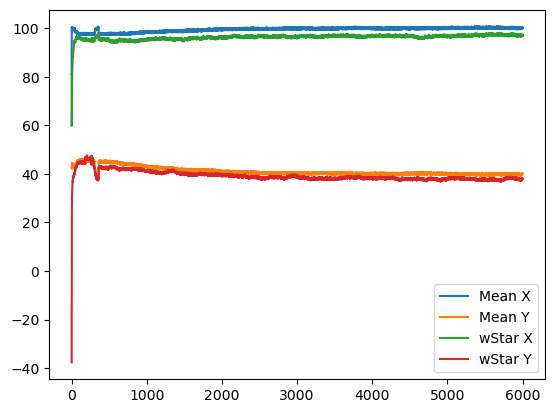

In [7]:
print(uncertaintyArray[-100:,:])


plt.plot(uncertaintyArray[:,0],label='Mean X')
plt.plot(uncertaintyArray[:,1],label='Mean Y')
# plt.plot(uncertaintyArray[:,2],label='w1 X')
# plt.plot(uncertaintyArray[:,3],label='w1 Y')
# plt.plot(uncertaintyArray[:,6],label='w3 X')
# plt.plot(uncertaintyArray[:,7],label='w3 Y')
# plt.plot(uncertaintyArray[:,10],label='Theta')
plt.plot(uncertaintyArray[:,11],label='wStar X')
plt.plot(uncertaintyArray[:,12],label='wStar Y')

# Distance Plots
# plt.plot(targetDist[:,0])
plt.legend()



In [8]:


target.trajectory[-100:,0]


array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.])

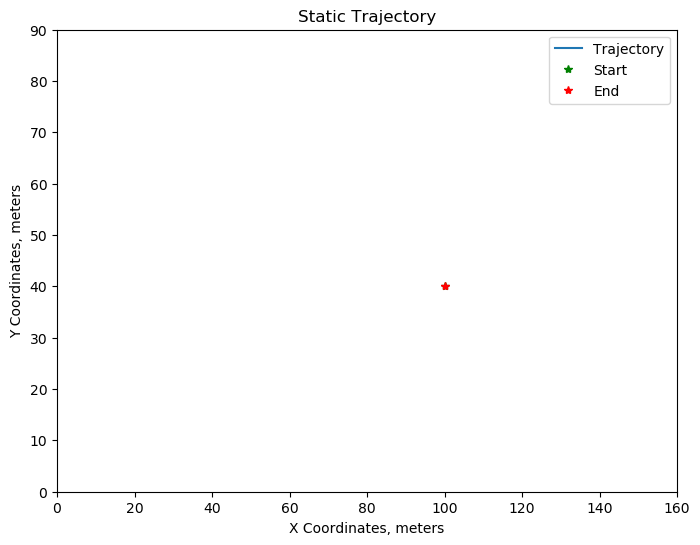

In [9]:
traj = robot.finalTrajectory
traj = target.trajectory
fig = plt.figure(figsize=(8,6))

start = 0
end = -1




ax = plt.axes()
# ax.scatter(robot.w[:,0], robot.w[:,1], c='r', label='waypoints')
# ax.plot(minsnap_trajectory(t)[:,0], minsnap_trajectory(t)[:,1], label='Trajectory')
ax.plot(traj[start:end,0], traj[start:end,1], label='Trajectory')
ax.plot(traj[start,0], traj[start,1],'g*',label='Start')
ax.plot(traj[end,0], traj[end,1],'r*',label='End')
ax.set_xlabel('X Coordinates, meters')
ax.set_ylabel('Y Coordinates, meters')
ax.set_title('Static Trajectory')
ax.set_xlim(arenaSize[0,0],arenaSize[0,1])
ax.set_ylim(arenaSize[1,0],arenaSize[1,1])
ax.legend()
# ax.legend()
# ax.plot(traj[:,-1])

# print(np.max(minsnap_trajectory(t,1)[:]))
# print(t[1]-t[0])


# debugging = True
# # Set debugging to true to verify that the derivatives up to 5 are continuous
# if debugging:
#   fig2 = plt.figure(figsize=(4,3))
# #   plt.plot(t, minsnap_trajectory(t,1)[:], label='1st derivative')
#   plt.plot(traj[start:end,2:4], label='1st Derivative')
#   plt.legend()

#   fig3 = plt.figure(figsize=(4,3))
# #   plt.plot(t, minsnap_trajectory(t,2)[:], label='2nd derivative')
#   plt.plot( traj[start:end,4:6], label='2nd Derivative')
#   plt.legend()

# #   fig4 = plt.figure(figsize=(4,3))
# # #   plt.plot(t, minsnap_trajectory(t,3)[:], label='3rd derivative')
# #   plt.plot( traj[start:end,6:8], label='3rd Derivative')
# #   plt.legend()

# #   fig5 = plt.figure(figsize=(4,3))
# # #   plt.plot(t, minsnap_trajectory(t,4)[:], label='4th derivative')
# #   plt.plot(traj[:,-1], traj[:,8:10], label='4th Derivative')

# #   plt.legend()


# plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d345d04-da85-4b95-91f8-a2840961b3ae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>